# COSC 526 / 426 - Assignment 07 
### Discussed: Mar 7, 2025
### Due: Mar 14, 2025
---

*Note: Running a cell will not rerun previous cells.  If you edit code in previous cells, you must rerun those cells.  We recommend using* `Run All` *to avoid any errors results from not rerunning previous cells.  You can find this in the menu above:* `Cell -> Run All`

During the Lecture 6, we learned about $k$-means clusterings. In a previous assignment, we learned to use PySpark's parallel versions of the `map` and `reduce` functions. In this assignment, we will be implementing the $k$-means algorithm in parallel with PySpark.

### Import PySpark
Run the cell below to verify that Java, Spark, and PySpark are successfully installed. The cell generates a dataset of numbers (i.e., 1, 2, 3, 4, 5, 6, 7, 8, 9, and 10) and computes their sum. The expected output is 45. If you run into an error, return to the Spark-Install scripts from before.

In [2]:
# Note: If this code does not execute, try uncommenting the following two lines
#import findspark
#findspark.init()

from pyspark import SparkContext
sc = SparkContext.getOrCreate()
data = sc.parallelize(range(1,10))
print(data.reduce(lambda x,y: x+y))
sc.stop()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/09 16:38:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


45


### Problem 1:
**Implement $k$-means in spark.**

Below we have provided you with several helper functions that can be used to implement $k$-means.

In [3]:
import numpy as np

# Add value1 and value 2
# Useful as a reduce function
def addValues(val1, val2):
    return val1 + val2

# Calculate the euclidian distance between two 2D points
# HINT: ref 1
# Input: point_a: np.array(x,y)
#        point_b: np.array(x,y)
# Return: distance
def dist(point_a, point_b):
    return np.sqrt(sum((point_a - point_b)**2))

# Find the centroid that the `point` is closest to and return the centroid's ID
# The centroid ID in this case is simply its index in the `centroids` list
# Input: point: np.array(x,y)
#        centroids: [np.array(x1,y1), np.array(x2,y2), ..., np.array(xK,yK)], 
#                   where K is the number of clusters
# Return: clusterID
def getClosestCentroidID(point, centroids):
    distances = [dist(point, centroid) for centroid in centroids]
    return np.argmin(distances)

# Convert the given `line` to a point
# As in assignment 4, we recommend using numpy arrays to store the (x,y)-coordinates of the points
# Input: line: "float float"
# Return: point: np.array(x,y)
def lineToPoint(line):
    return np.array([float(x) for x in line.split()])

# Given a point (i.e., (x,y) and a list of centroids (i.e., list of points),
# find the closest centroid and assign that cluster to the point
# Input: points_rdd: <<np.array(x1,y1), np.array(x2,y2), ... np.array(xN,yN)>>,
#                    where N is the number of lines in the file
#        centroids:  [np.array(x1,y1), np.array(x2,y2), ..., np.array(xK,yK)],
#                    where K is the number of clusters
# Return: RDD of clustered points: <<(clusterID, np.array(x1, y1)), (clusterID, np.array(x2, y2)), ...>>
def assignPointsToClosestCluster(points_rdd, centroids):
    return points_rdd.map(lambda x: (getClosestCentroidID(x, centroids), x))
    
# Read in the file and convert each line into a point (using `lineToPoint`) with Spark
# Return: RDD of points: <<np.array(x1,y1), np.array(x2,y2), ... np.array(xN,yN)>>,
#                        where N is the number of lines in the file
def readPointsFromFile(filename):
    sc = SparkContext.getOrCreate()
    lines = sc.textFile (filename)
    points = lines.map(lineToPoint)
    return points

# Sum the distance that each centroid moved by
# Input: old_centroids: [np.array(x1,y1), np.array(x2,y2), ..., np.array(xK,yK)],
#                       where K is the number of clusters
#        new_centroids: [np.array(x1,y1), np.array(x2,y2), ..., np.array(xK,yK)],
#                       where K is the number of clusters
# Return: sum of distances
def calculateChangeInCentroids(old_centroids, new_centroids):
    return sum([dist(old, new) for old, new in zip(old_centroids, new_centroids)])

#### References
- [1: euclidian distance for two dimensions](https://en.wikipedia.org/wiki/Euclidean_distance#Two_dimensions)

----

In the next cell, you will implement the key components of the $k$-means clustering algorithm.  The first piece of the algorithm is calculating the mean coordinates of each cluster. In plain terms, to calculate the mean (i.e., average) $x$-coordinate of Cluster $j$, you must first find all of the points in the cluster. Then you must sum their $x$-coordinate values.  Finally, you divide that sum by the number of points in the cluster.  This produces the mean $x$-coordinate.  You must repeat this process for the $y$-coordinate (or for greater efficiency, you can perform it in parallel with the $x$-coordinate calculation). The equation below demonstrates how to calculate the mean coordinates of a given cluster:

$$\overline{Cluster_j} = \left\langle \frac{x_1 + x_2 + \ldots + x_n}{n} , \frac{y_1 + y_2 + \ldots + y_n}{n} \right\rangle$$ where $$n = \left\vert Cluster_j \right\vert$$ and $$\langle x_1, y_1\rangle, \langle x_2, y_2\rangle, \ldots, \langle x_n, y_n\rangle \in Cluster_j$$

Your task is to **implement the `calculateClusterMeans` function and then test it against our provided test case**.  You will need to calculate the expected output by hand to ensure that your function produces the correct result.

In [4]:
# Calculate the mean coordinates of each cluster.
# Input: clustered_points_rdd: <<clustered_point1, clustered_point2, ..., clustered_pointN>>,
#                              where N is the number of clustered_points, and
#                              where each clustered_point looks like (clusterID, np.array(x,y))
# Return: [centroid1, centroid2, ..., centroidK],
#         where K is the number of clusters, and
#         where each centroid is np.array(x,y)
def calculateClusterMeans(clustered_points_rdd):
    # Sum the xs and ys of all points in each cluster
    # HINT: ref 1
    cluster_sums = clustered_points_rdd.reduceByKey(lambda point1, point2: point1 + point2)
    
    # Count the number of points in each cluster
    # HINT: ref 2
    cluster_counts = clustered_points_rdd.countByKey()
    
    sums = cluster_sums.collect()
    
    # Divide the x,y sums for each cluster by the number of points in each cluster
    cluster_means = []
    for cluster_id, sum_points in sorted(sums):
        cluster_mean = sum_points / cluster_counts[cluster_id]
        cluster_means.append(cluster_mean)
    
    return cluster_means

sc = SparkContext.getOrCreate()
test_clustered_points = sc.parallelize([(0, np.array([1.0, 2.0])),
                                        (0, np.array([0.5, 1.0])),
                                        (1, np.array([4.0, 8.0])),
                                        (1, np.array([0.0, -1.0]))
                                       ])
print(calculateClusterMeans(test_clustered_points))

[array([0.75, 1.5 ]), array([2. , 3.5])]


#### References
- [1: reduceByKey](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.reduceByKey.html#pyspark.RDD.reduceByKey)
- [2: countByKey](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.countByKey.html#pyspark.RDD.countByKey)

----

You now have all the tools you need to write the main $k$-means function.  In this function, **your task is to read in the points from the provided file, cluster the points into $K$ clusters, and then return the clustering results (cluster centroids and clustered points)**.   Your code should accept two arguments: 1) the filename of the file containing the data that should be clustered and 2) the number of clusters to create. The input files we provide (`contig.txt` and `mickey.txt`) have one data point per line; the coordinates of the data points are two space delimited floating point numbers (i.e., $x$ and $y$). Your code should output the final centroids of each cluster as well as each point and its assigned cluster. Remember to use the functions that we have given you and that you have implemented in the previous cells (i.e., `readPointsFromFile`, `assignPointsToClosestCluster`, `calculateClusterMeans`, `assignPointsToClosestCluster`, and `calculateChangeInCentroids`.

We have provided you with a very small, simple dataset to test against (i.e., `simple.txt`). This dataset is small enough that it can be printed out in its entirety.  It contains two very distinct clusters.  

In [8]:
import math

# Cluster the points in the file into K clusters using k-means clustering
# Input: filename: file that contains the points (one per line)
#        K: number of clusters
# Return: [centroid1, centroid2, ..., centroidK] and [clustered_point1, clustered_point2, ..., clustered_pointN]
#         where K is the number of clusters,
#         where N is the number of points,
#         where centroid is np.array(x,y), and
#         where each clustered_point is (clusterID, np.array(x,y))
def clusterFile(filename, K):
    # Read in the file and convert to points
    points_rdd = readPointsFromFile(filename)
    
    # Randomly choose K points as the centroids
    # HINT: ref 1
    centroids = points_rdd.takeSample(False, K)
    
    # Assign each point to the centroid closest to it
    clustered_points_rdd = assignPointsToClosestCluster(points_rdd, centroids)
    
    # Begin the iterative portion of k-means,
    # continue until the changes in centroids are very small (e.g., < .0001)
    change_in_centroids = math.inf
    while change_in_centroids > 0.0001:
        old_centroids = centroids
        # Calculate the new centroids based on the means of the current clusters
        centroids = calculateClusterMeans(clustered_points_rdd)
        
        # Assign the points to the new centroids
        clustered_points_rdd = assignPointsToClosestCluster(points_rdd, centroids)
        
        # Calculate the change in the centroids since the last iteration
        change_in_centroids = calculateChangeInCentroids(old_centroids, centroids)

    return centroids, clustered_points_rdd.collect()

centroids, clustered_points = clusterFile('simple.txt', 2)

print("Clustered Data")
prev_cluster_id = -1
for clustered_point in sorted(clustered_points, key=lambda x: x[0]):
    cluster_id, point_coords = clustered_point
    if cluster_id > prev_cluster_id:
        print("\tCluster {}:".format(cluster_id))
    prev_cluster_id = cluster_id
    print("\t\tCoordinates: {}".format(point_coords))

print("Cluster Centers")
for idx, centroid in enumerate(centroids):
    print("\tCluster {}: {}".format(idx, centroid))

Clustered Data
	Cluster 0:
		Coordinates: [-4.44375343  0.        ]
		Coordinates: [-4.42332439  0.        ]
		Coordinates: [-4.21117849  0.        ]
		Coordinates: [-4.19834549  0.        ]
		Coordinates: [-4.13252583  0.        ]
	Cluster 1:
		Coordinates: [3.38701979 0.        ]
		Coordinates: [3.56450093 0.        ]
		Coordinates: [3.67432789 0.        ]
		Coordinates: [3.76562207 0.        ]
		Coordinates: [3.88865504 0.        ]
		Coordinates: [4.20330179 0.        ]
Cluster Centers
	Cluster 0: [-4.28182553  0.        ]
	Cluster 1: [3.74723792 0.        ]


#### References
- [1: takeSample](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.takeSample.html#pyspark.RDD.takeSample)

----

In the cell below, **your task is to devise a way to visualize the clusters you have created** (to verify that the algorithm works as expected on larger datasets).  We have provided you with code that plots each point (using `matplotlib`), but you must extend the code to plot the cluster centers as well as color each point based on the cluster it is in.

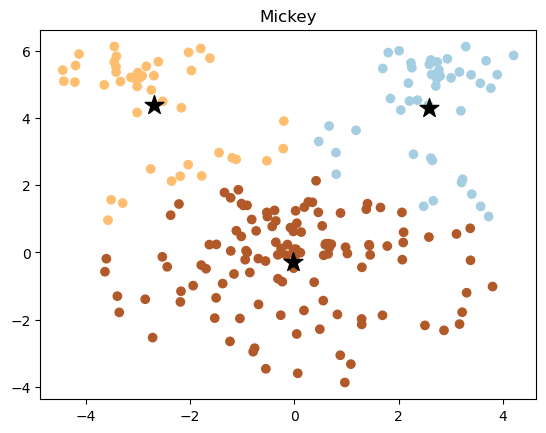

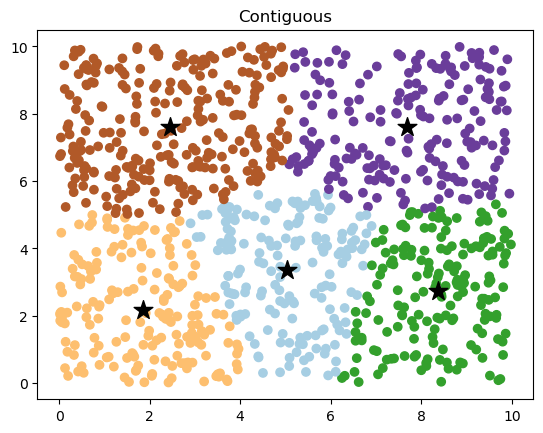

In [9]:
import matplotlib as mpl
from matplotlib import pyplot as plt

# Plot the clustered points along with the cluster centers.
# The points should be colored based on the cluster they are in.
# Input: centroids: [(x1,y1), (x2,y2), ..., (xK,yK)], 
#                   where K is the number of clusters
#        clusteredPoints: [(clusterID, (x1,y1)), (clusterID, (x2,y2)), ... (clusterID, (xN,yN))], 
#                         where N is the number of points
def plotClusters(centroids, clustered_points, title=None):
    if len(clustered_points) <= 0:
        return
    
    # Extract the cluster ids and points from clusteredPoints
    # See ref 1
    cluster_ids, points = zip(*clustered_points)
    # Extract x and y values from the points and centroids
    point_xs, point_ys = zip(*points)
    centroid_xs, centroid_ys = zip(*centroids)
    
    fig = plt.figure()
    
    # Plot each cluster center as a black star (that is slightly larger
    #      than the data points plotted below)
    # HINT: ref 4  (specifically look at the 'marker', 's', and 'c' keyword args)
    plt.scatter(centroid_xs, centroid_ys, marker='*', s=200, c='black')
    
    # Pick a color to use for each cluster (e.g., cluster1 is "blue", cluster2 is "red", ...)
    # HINT: ref 2, ref 3
    num_clusters = len(centroids)
    cmap = plt.cm.get_cmap('Paired', num_clusters)
    norm = mpl.colors.Normalize(vmin=0, vmax=num_clusters-1)


    
    # Plot each point in the figure using a scatter plot
    # Each point should be colored based on the cluster that it is in
    # HINT: ref 4 (specifically look at the 'marker', 'c', 'cmap', and 'norm' keyword args)
    # The 'zorder' keyword argument is used here to make sure the points are drawn behind
    #      the cluster center stars
    plt.scatter(point_xs, point_ys, marker='o', c=cluster_ids, cmap=cmap, norm=norm, zorder=-1)
    
    if title:
        plt.title(title)
    plt.show()

centroids, clustered_points = clusterFile('mickey.txt', 3)
plotClusters(centroids, clustered_points, title="Mickey")
centroids, clustered_points = clusterFile('contig.txt', 5)
plotClusters(centroids, clustered_points, title="Contiguous")

#### References
- [1: zip(*)](https://stackoverflow.com/a/5917600)
- [2: using normalization and colormaps in matplotlib](https://stackoverflow.com/questions/43132300/how-can-i-normalize-colormap-in-matplotlib-scatter-plot)
- [3: colormap reference](https://matplotlib.org/examples/color/colormaps_reference.html)
- [4: scatter](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.scatter.html#matplotlib.pyplot.scatter)

### Things to Consider:
* How do you choose $K$ for your dataset?
  * A popular technique is the elbow method:
    * https://pythonprogramminglanguage.com/kmeans-elbow-method/
    * https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set#The_elbow_method
* Do you always get the same results from $k$-means?  Is it non-determinisitc?  Is this an error in your code or a feature of the algorithm?
* How would you optimize the code to work for larger datasets (e.g., 100GBs of points)?
* How would you generalize the code to work for larger-dimensionality datasets?

1. In the code, the K is provided and hardcoded. Instead of making assumptions, you can use the elbow method to try out different values of K and look for the "elbow" point where adding more clusters has less effect. 

2. k-means can sometimes get different results without changing anything which makes it non-deterministic. However, it is a feature of the algorithm and not an error in the code.

3. I would ensure I'm using Spark to utilize the parallel computing and cache the reused RDDs when I can. Maybe play with the value of the changes in centroids to be small but not uneccessarily small that more iteration doesn't equate to better results.

4. I would generalize the code by using dimensionality reducation techniques (PCA, SVD, LDA) to reduce the number of features but still keep the information. 

### Problem 2: Project

In class, we have filled and discussed the form COSC 526 / 426 - Planning your Project (Step 1), available at: https://forms.gle/nj2frFtKii5WSjXX8

For the next week, fill out this other form -- COSC 526 / 426 - Planning your Project (Step 2): https://forms.gle/kPQoW9AfSmrBMvmV8

* Note: the coding in this assignment is very easy. The part of the assignment that should take more time is to prepare the answers for the second form.*

### Problem 3: Video

During Lecture 6, we watched a video of Ben Wellington, who  uses data to tell stories - https://www.youtube.com/watch?v=6xsvGYIxJok. List and briefly discuss how you can transfer the four steps of story telling that Wellington applies for his work to your project? Hints: he refers to four key steps that drive his work. (max 200 words)


Wellington's four steps to storytelling are "connect with people's experience," "focus on one idea," "keep it simple," and "explore things you know best." In my project, the social determinants of health (SDOH) data are indexed based on the census tract of the entire United States. To keep it simple and connect with people's experiences, I will limit my data to Tennessee to make it relatable to my Tennesseean peers. From distance to hospitals to the percentage of the population having a certain degree, there are many questions to ask with the 329 variables. To focus on one idea, I want to choose the variables about the percentage of those employed in certain areas and their education levels. Then I can infer what jobs your education could take you in different parts of Tennessee, which is what we have to think about after graduation. Education and finding jobs are things I'm more familiar with than the other social determinants like health insurance and food insecurity.

### Reflect on your experience with the lecture and assignment:

Q1: Resource usage: What external resources (websites, books, etc.) did you consult while working on the problems? Please list them.

Q2: Debugging and error resolution: How often did you encounter and resolve errors or bugs during the assignment? Could you describe each occurrence in detail?

Q3: Gained knowledge: What lessons or insights you learned from solving these problems? How do you apply these insights in future coding projects or problem-solving scenarios?

Q4: Collaborative experiences: If you consulted with others, explain how this collaboration influenced your problem-solving approach. If you consulted with others, can you give an example of how you helped a peer or how a peer's advice helped you?

**Important Note:** Your reflections and experiences shared in response to these questions are as crucial as the solutions for the coding problems. Responses that are too brief or limited to a few words will not suffice and may  affect the pass grade for your assignment.

1. I did not consult any external resources besides the ones referenced in the notebook.
2. I did not encounter any serious errors or bugs during the assignment. The only problem I had was choosing which colormap to use to improve readability of the data points.
3. Calculating k-means and the clusters was really simple with all of the helper functions. It really improves the readability of the code by making reusable functions and breaking the code up. I also learned how to better utilize scatterplot like adding the stars and making each cluster a different color. Knowing how to make more complex visualizations is great for showing off data.
4. I did not consult with others. If I did, it probably would have been about double-checking math and answers.